# Project 2

In this project, you will implement the exploratory analysis plan developed in Project 1. This will lay the groundwork for our our first modeling exercise in Project 3.

### Step 1: Load the python libraries you will need for this project 

In [9]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pylab as pl
import numpy as np
import seaborn as sns
from math import log

# Statistical Tests
from scipy.stats import kstest, mannwhitneyu, norm
from scipy import stats
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import ztest

%matplotlib inline

### Step 2: Read in your data set 

In [4]:
#Read in data from source 
df_raw = pd.read_csv("../assets/admissions.csv")
print df_raw.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Questions
#### Question 1. How many observations are in our dataset? 


In [3]:
df_raw.count()

admit       400
gre         398
gpa         398
prestige    399
dtype: int64

Answer: 400 observations, although there are some rows with null values in some of the columns

#### Question 2. Create a summary table

In [3]:
df_raw.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [4]:
df_raw.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
df_raw.groupby('prestige').median()

,admit,gre,gpa
prestige,,,
1.0,1,600.0,3.53
2.0,0,600.0,3.38
3.0,0,580.0,3.43
4.0,0,560.0,3.33


#### Question 3. Why would GRE have a larger STD than GPA?

Answer: 

#Most scores for the GRE are between 397 and 800, which is a huge difference (403 points - see quantile chart below). Whereas the GPA is mostly between 4.0 and 2.76 (only 1.24 points). Clearly this is mostly because the two have very different logic. The highest GPA possible is a 4.0 - so already you're not going to have alot of deviation from the mean with GPA. 

#They both have tons of outliers though - the GRE has 25 people with a perfect score and there are 28 people who have a perfect 4.0 for GPA!

In [10]:
df_raw['gre'].std()

115.62851309152948

In [11]:
df_raw['gpa'].std()

0.3806303800566138

In [15]:
df_raw[['gpa', 'gre']].quantile([.95, .05])

,gpa,gre
0.95,4.0000,800.0
0.05,2.7555,397.0


In [16]:
df_raw[['gpa', 'gre']].quantile([.75, .25])

,gpa,gre
0.75,3.67,660.0
0.25,3.13,520.0


In [18]:
df_raw[df_raw['gre'] == 800.0].count()

admit        0
gre         25
gpa          0
prestige     0
dtype: int64

In [19]:
df_raw[df_raw['gpa'] == 4.0].count()

admit       28
gre         28
gpa         28
prestige    28
dtype: int64

#### Question 4. Drop data points with missing data


In [9]:
df_raw.columns

Index([u'admit', u'gre', u'gpa', u'prestige'], dtype='object')

In [5]:
df_dropped = df_raw.dropna(how='any')

#### Question 5. Confirm that you dropped the correct data. How can you tell? 

Answer: 

In [ ]:
df_dropped.to_csv('df_dropped.csv') #validated in excel - it worked

You can also validate by doing a comparison using isnull(), first the nulls from the original dataframe, and then the rows from the adjusted dataframe as shown below.

In [22]:
df_raw[df_raw.isnull().any(axis=1)]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0
236,1,660.0,NaN,NaN


In [23]:
df_dropped[df_dropped.isnull().any(axis=1)] #none came up because they were all removed

,admit,gre,gpa,prestige


#### Question 6. Create box plots for GRE and GPA

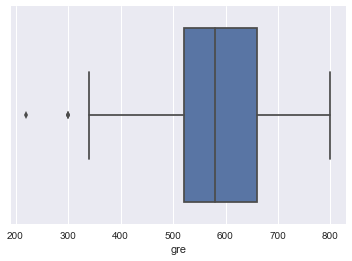

In [13]:
#df_raw['gre'].plot(kind='box')
sns.boxplot(df_dropped.gre, orient='h')

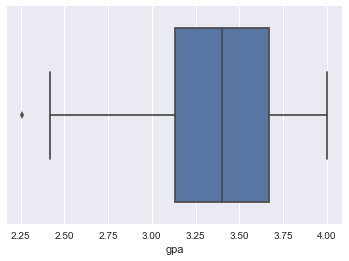

In [14]:
#df_raw['gpa'].plot(kind='box')
sns.boxplot(df_dropped.gpa, orient='h')

#### Question 7. What do this plots show?

Answer: First off it shows the basics: minimum, first quartile, median, third quartile, maximum.

#We're also seeing that it shows additional outliers for the lower end of GRE (first box plot). GPA may have felt squished along the mean above, however it's data points are more widely spread throughout the first and third quartile. Interestingly there is a big spread for GPA between the 0 and .25 quartile - this makes me think that the distribution is negative skewed. The median for both is much closer to the upper ranges for both columns - it may have something to do with all of the high achievers with perfect GREs and GPAs. GRE looks like it has a little bit of a negative skew as well.

#### Question 8. Describe each distribution 

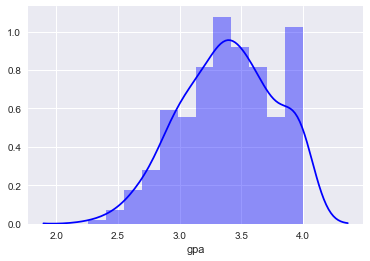

In [18]:
# plot the distribution of each variable 
sns.distplot(df_dropped['gpa'], color='blue')

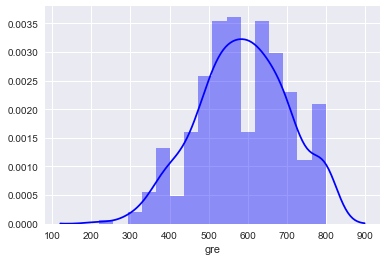

In [19]:
sns.distplot(df_dropped['gre'], color='blue')

As shown above and described in the last question- both distribitions are right skewed due the pool of applicants and high achievers - more so with GPA. GPA's median, just below 3.5, doesn't leave alot of room - whereas the bottom 50% are between just below 2.5 and just below 3.5 which is a much greater range. 

#### Question 9.  If our model had an assumption of a normal distribution would we meet that requirement? 

Answer: It depends, visually - GRE seems close - but lets test for it below.

In [21]:
print 'GPA Result'
print kstest(df_dropped['gpa'], 'norm')

print '\n'

print 'GRE Result'
print kstest(df_dropped['gre'], 'norm')

GPA Result
KstestResult(statistic=0.98972085476178895, pvalue=0.0)


GRE Result
KstestResult(statistic=1.0, pvalue=0.0)


Our analysis shows that there is not enough evidence (at the .05 sensitivity level) to support the null hypothesis of normality of GPA & GRE and as a result we accept the alternative hypothesis of non-normality of GPA & GRE.

#### Question 10.  Does this distribution need correction? If so, why? How? 

Answer: It does, both distributions being right skewed would need to be corrected for the large spread of data points between 0-50% and the opposite on the other side. You could make the distribution normal by implementing some kind of transformation. The are many ways to do it: logarithmic, box-cox, etc - depending on the distribution.

#### Question 11. Which of our variables are potentially colinear? 

In [26]:
df_dropped.corr()

,admit,gre,gpa,prestige
admit,1.000000,0.181202,0.174116,-0.243563
gre,0.181202,1.000000,0.382408,-0.124533
gpa,0.174116,0.382408,1.000000,-0.060976
prestige,-0.243563,-0.124533,-0.060976,1.000000


GRE and GPA are the most colinear, which shows a weak coorelation at 38%. Interestingly there is a negative weak correlation between prestige and admissions, GRE and GPA - which implies that the prestige of the university isn't as important or may even have the opposite effect. The findings for prestige are odd, although that data is categorical. I've broken out prestige into dummy variables below which provides more insight.

In [23]:
#pd.get_dummies(df_dropped.prestige).head()
df_dropped_dum = pd.concat([df_dropped, pd.get_dummies(df_dropped['prestige'])], axis=1)
df_dropped_dum.columns

Index([u'admit', u'gre', u'gpa', u'prestige', 1.0, 2.0, 3.0, 4.0], dtype='object')

In [42]:
df = df_dropped_dum.drop('prestige', 1) #delete prestige column

In [43]:
df.corr() # now this makes more sense

,admit,gre,gpa,1.0,2.0,3.0,4.0
admit,1.000000,0.181202,0.174116,0.204689,0.067459,-0.122302,-0.133859
gre,0.181202,1.000000,0.382408,0.088277,0.058454,-0.074380,-0.069046
gpa,0.174116,0.382408,1.000000,0.068304,-0.050507,0.070881,-0.087671
1.0,0.204689,0.088277,0.068304,1.000000,-0.328493,-0.282120,-0.191989
2.0,0.067459,0.058454,-0.050507,-0.328493,1.000000,-0.510469,-0.347385
3.0,-0.122302,-0.074380,0.070881,-0.282120,-0.510469,1.000000,-0.298345
4.0,-0.133859,-0.069046,-0.087671,-0.191989,-0.347385,-0.298345,1.000000


So now we have some better insight. A prestige ranking of one shows a weak correlation between admissions and prestige - basically a very good university gives you a better chance of being accepting. It falls to a much lower correlation at two, and then a negative correlation at 3 and 4. So basically, the best indicator of acceptance is a prestige ranking of 1, more so then GPA or GRE. 

#We can also see that applicants from from more prestigious universities have a high correlation with GRE - suggesting that the better your undergrad, the higher your GREs. 

#Based on the below groupby mean, it does look as though there is a higher GPA & GRE the better the university although GPAs for prestige rank 2 is slightly lower (this may just be based on the sample).

In [47]:
df_dropped.groupby('prestige').mean()

,admit,gre,gpa
prestige,,,
1.0,1,600.0,3.530
2.0,0,600.0,3.385
3.0,0,580.0,3.430
4.0,0,560.0,3.330


#### Question 12. What did you find?

Answer: Your undergrad university is the best indictor of acceptance. So basically, you better get your kid into a good preschool - because if previous studies showed that your prior school for kindergarten, elementary school, middle school, high school, undergrad is an indicator of acceptance - start early (jk)!

We also found that GRE & GPA are for the *most* part highly correlated with a prestige rank of 1 and 2 - showing that if you went to a good university, you probably had a good GPA and GRE.

#### Question 13. Write an analysis plan for exploring the association between grad school admissions rates and prestige of  undergraduate schools.

Answer: 

#Determining normality & distribution mean/median and variances:
    #1) Assume that the standard Deviation is not known
    #2) Delete rows with null values
    #3) Do a KS test to determine if the distribution is normal/ not normal. It is most likely still non-normal.
    #4) If the distribution is not normal, determine if there are outliers, which would have an impact on the mean, at the low and high intervals of 25 and 75%. 
        #a) Lower Outliers< Q1-1.5 * IQR
        #b) High Outliers> Q3+ 1.5 * IQR
    #5) Check colineartity for the independence between variables in the dataset by doing a correlation matrix of GRE, GPA and Acceptance. Include prestige only once it is broken out into dummy variables
    #6) If the distribution is not normal do a Mann-Whitney test to look at the medians, then do a Levene test to look at the variances between the predictors. This may require doing something different as each predictor may technically be seen as a one sample scenario.
    #7) If the distributions are normal do a T-Test (std deviation not known) to look at the means and a Bartlet test to look at the variances

#Doing the analysis:
    #1)Delete rows with null values
    #2)Do a groupby for prestige, aggregating by mean
    #3)Break out the dummy variables
    #4)Do a correlation matrix with the regular columns and the dummy variables, but delete the prestige column
    #5)Create the distribution & boxplots to graph visually where the datapoints fall
    #6)Note comparison of means in the groupby under prestige to the correlations of the dummy variables
    #7)Note distribution's datapoints and outliers

#### Question 14. What is your hypothesis? 

Answer: A prestige ranking of one is the best indicator of admissions

## Bonus/Advanced

#### 1. Bonus: Explore alternatives to dropping obervations with missing data

You could make a fake number by using the mean or median for that specific GRE, GPA, acceptance and prestige ranking

#### 2. Bonus: Log transform the skewed data

D:\Users\us36986\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


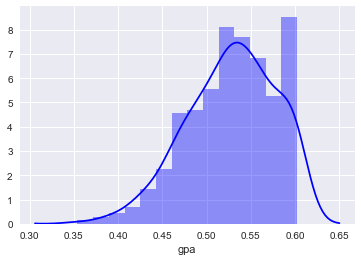

In [24]:
df_log = np.log10(df_dropped_dum)
sns.distplot(df_log['gpa'], color='blue')

In [28]:
df_log.corr()

,admit,gre,gpa,prestige,1.0,2.0,3.0,4.0
admit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gre,NaN,1.000000,0.380772,-0.123120,NaN,NaN,NaN,NaN
gpa,NaN,0.380772,1.000000,-0.059213,NaN,NaN,NaN,NaN
prestige,NaN,-0.123120,-0.059213,1.000000,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3. Advanced: Impute missing data

In [26]:
df_raw[df_raw.isnull().any(axis=1)]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0
236,1,660.0,NaN,NaN


In [27]:
df_fill = df_raw.fillna(df_raw.mean()) #filling the NA values with the mean for that column
df_fill[df_fill.isnull().any(axis=1)] #confirmed that the NA values have been filled
#There is a way to do this with skikit learn but I wasn't able to figure it out

,admit,gre,gpa,prestige
